In [47]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
from community import community_louvain
import matplotlib.cm as cm
import itertools
import seaborn as sns

In [48]:
concat_voted_df = list()
for date in [2019, 2020, 2021]:
    votes_df = pd.read_csv(f"datasets/votacoesVotos-{date}.csv", delimiter=";")
    votes_df = votes_df[['idVotacao',
                         'deputado_id', 'deputado_nome',
                         'deputado_siglaPartido']]
    votes_df = votes_df.rename(columns={"deputado_siglaPartido": "siglaBancada"})
    concat_voted_df.append(votes_df)

votes_gr_df = pd.concat(concat_voted_df, ignore_index=True)
votes_grouped_df = votes_gr_df.groupby(by=["deputado_id", "deputado_nome", "siglaBancada"]).agg({'idVotacao': lambda x: ','.join(x),}).reset_index()
GO = nx.read_weighted_edgelist("networks/vote19-20-21-orientado-not-normalized.txt", nodetype=int)
GL = nx.read_weighted_edgelist("networks/vote19-20-21-liberado-not-normalized.txt", nodetype=int)

In [49]:
dep_sigla_dict = dict(zip(votes_grouped_df['deputado_id'], votes_grouped_df['siglaBancada']))
nx.set_node_attributes(GO, dep_sigla_dict, name="party")
nx.set_node_attributes(GL, dep_sigla_dict, name="party")

In [50]:
dg_GO = np.array([int(dg) for (nd, dg) in GO.degree()])
dg_GL = np.array([int(dg) for (nd, dg) in GL.degree()])

In [51]:
# Characterization ORIENTADO
print(f"Nodes: {GO.number_of_nodes()}")
print(f"Edges: {GO.number_of_edges()}")
print(f"Global: {nx.transitivity(GO)}")
print(f"Degree max, min, mean, std: {dg_GO.max()}, "
      f"{dg_GO.min()}, {dg_GO.mean()}, {dg_GO.std()}")
print(f"Density: {nx.density(GO)}")
w_edges_o = sorted(GO.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
e_w_o = 0
for e in w_edges_o:
    e_w_o += e[2]['weight']
e_w_o = e_w_o/len(w_edges_o)
print(f"Edge weight max, min, mean: {w_edges_o[0][2]['weight']}, {w_edges_o[-1][2]['weight']}, {e_w_o}")

Nodes: 574
Edges: 158660
Global: 0.9770311042909179
Degree max, min, mean, std: 573, 91, 552.822299651568, 44.88929228623447
Density: 0.9647858632662617
Edge weight max, min, mean: 455.0, 1.0, 126.22962939619312


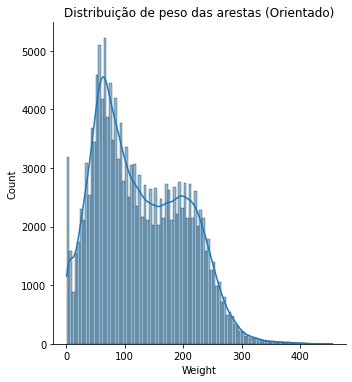

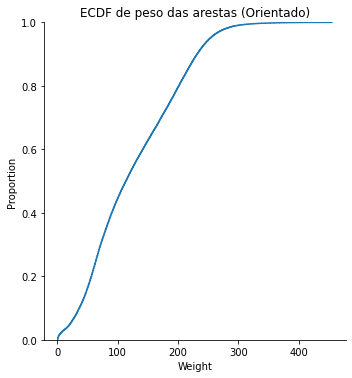

In [128]:
# Plot weight distribution ORIENTED
plot_w_edges = [con[2]['weight'] for con in w_edges_o]
p1 = sns.displot(plot_w_edges, kde=True)
p1.set(xlabel="Weight", title="Distribuição de peso das arestas (Orientado)")
p1.savefig("figs/weight_distrib_oriented.png")

p2 = sns.displot(plot_w_edges, kind="ecdf")
p2.set(xlabel="Weight", title="ECDF de peso das arestas (Orientado)")
p2.savefig("figs/weight_distrib_ecdf_oriented.png")

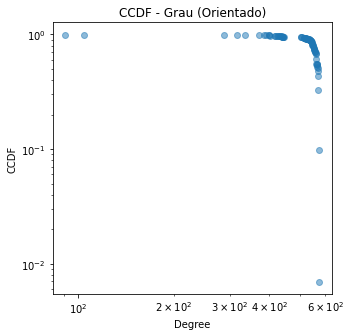

In [125]:
# CCDF
x_g_o, f_k_g_o = np.unique(dg_GO, return_counts=True)
cdf_g_o = f_k_g_o.cumsum()/f_k_g_o.sum()
ccdf_g_o = 1-cdf_g_o

plt.figure(figsize=(5,5))
plt.scatter(x_g_o, ccdf_g_o, alpha=0.5)
plt.title('CCDF - Grau (Orientado)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.savefig("figs/ccdf_oriented.png")
plt.show()

In [54]:
# Characterization LIBERADO
print(f"Nodes: {GL.number_of_nodes()}")
print(f"Edges: {GL.number_of_edges()}")
print(f"Global: {nx.transitivity(GL)}")
print(f"Degree max, min, mean, std: {dg_GL.max()}, "
      f"{dg_GL.min()}, {dg_GL.mean()}, {dg_GL.std()}")
print(f"Density: {nx.density(GL)}")
w_edges_l = sorted(GL.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
e_w_l = 0
for e in w_edges_l:
    e_w_l += e[2]['weight']
e_w_l = e_w_l/len(w_edges_l)
print(f"Edge weight max, min, mean: {w_edges_l[0][2]['weight']}, {w_edges_l[-1][2]['weight']}, {e_w_l}")

Nodes: 559
Edges: 31653
Global: 0.587510858298792
Degree max, min, mean, std: 260, 3, 113.24865831842575, 60.83786535824848
Density: 0.20295458480004616
Edge weight max, min, mean: 15.0, 1.0, 1.5662022557103592


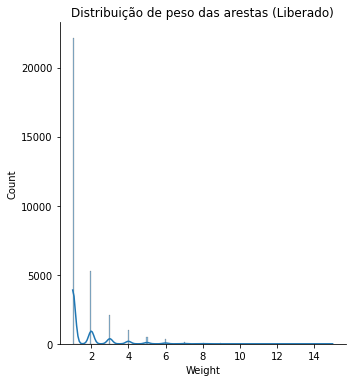

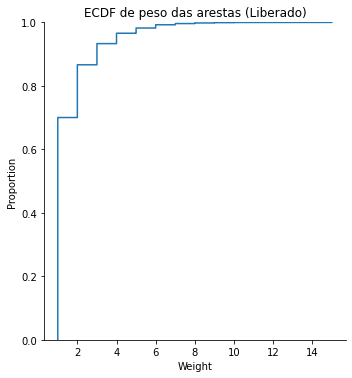

In [129]:
# Plot weight distribution
plot_w_edges_l = [con[2]['weight'] for con in w_edges_l]
p1_l = sns.displot(plot_w_edges_l, kde=True)
p1_l.set(xlabel="Weight", title="Distribuição de peso das arestas (Liberado)")
p1_l.savefig("figs/weight_distrib_free.png")

p2_l = sns.displot(plot_w_edges_l, kind="ecdf")
p2_l.set(xlabel="Weight", title="ECDF de peso das arestas (Liberado)")
p2_l.savefig("figs/weight_distrib_ecdf_free.png")

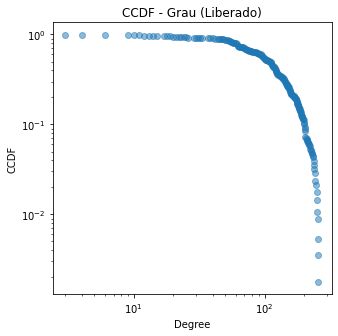

In [126]:
# CCDF
x_g_l, f_k_g_l = np.unique(dg_GL, return_counts=True)
cdf_g_l = f_k_g_l.cumsum()/f_k_g_l.sum()
ccdf_g_l = 1-cdf_g_l

plt.figure(figsize=(5,5))
plt.scatter(x_g_l, ccdf_g_l, alpha=0.5)
#plt.plot(x_g_l, ccdf_g_l, alpha=0.5)
plt.title('CCDF - Grau (Liberado)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.savefig("figs/ccdf_free.png")

plt.show()

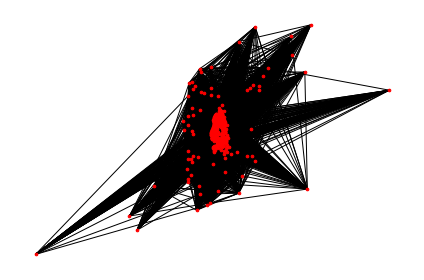

In [57]:
# Draw graph
elarge = [(u, v) for (u, v, d) in GO.edges(data=True) if d["weight"] >= 0.5]
esmall = [(u, v) for (u, v, d) in GO.edges(data=True) if d["weight"] < 0.5]

pos = nx.spring_layout(GO, seed=7)
nx.draw_networkx_nodes(GO, pos, node_size=7, node_color="red")
nx.draw_networkx_edges(GO, pos, edgelist=elarge, width=1)
nx.draw_networkx_edges(
    GO, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="grey", style="dashed"
)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [58]:
lv_communities = community_louvain.best_partition(GL)
new_dict = {}
for k, v in lv_communities.items():
    new_dict.setdefault(v, []).append(k)
lv = list(new_dict.values())
print(nx_comm.modularity(GL, lv))

0.41371604945618184


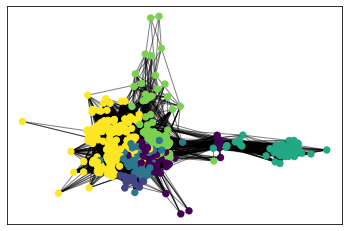

In [59]:
# draw the graph
pos = nx.spring_layout(GL)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(lv_communities.values()) + 1)
nx.draw_networkx_nodes(GL, pos, lv_communities.keys(), node_size=40,
                       cmap=cmap, node_color=list(lv_communities.values()))
nx.draw_networkx_edges(GL, pos, alpha=0.5)
plt.show()

0.3240185083039421


No handles with labels found to put in legend.


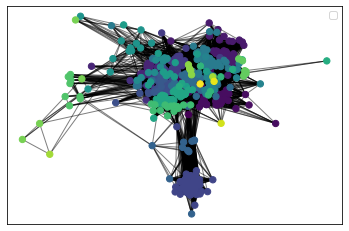

In [60]:
# set attribute as community
dep_new_dict = {}
for k, v in dep_sigla_dict.items():
    dep_new_dict.setdefault(v, []).append(k)
dp = list(dep_new_dict.values())

new_partition = list()
for partition in dp:
    nodes = list()
    for n in partition:
        try:
            GL[n]
            nodes.append(n)
        except:
            pass
    new_partition.append(nodes)

print(nx_comm.modularity(GL, new_partition))

new_partition_p = dict()
i = 0
for partition in new_partition:
    for n in partition:
        new_partition_p[n] = i
    i += 1

# draw the graph
pos_2 = nx.spring_layout(GL)
# color the nodes according to their partition
cmap_2 = cm.get_cmap('viridis', len(list(set(dep_sigla_dict.values()))))
nx.draw_networkx_nodes(GL, pos_2, new_partition_p.keys(), node_size=40,
                       cmap=cmap_2, node_color=list(new_partition_p.values()),
                       )
nx.draw_networkx_edges(GL, pos_2, alpha=0.5)
plt.legend()
plt.show()

In [61]:
# Medium distance inside party
inv_dep_sigla_dict = {}
for k, v in dep_sigla_dict.items():
    inv_dep_sigla_dict[v] = inv_dep_sigla_dict.get(v, []) + [k]

dep_sigla_combination = {}
for k, v in inv_dep_sigla_dict.items():
    dep_sigla_combination[k] = list(itertools.combinations(v,2))

In [62]:
GO_n = nx.read_weighted_edgelist("networks/vote19-20-21-orientado.txt", nodetype=int)
GL_n = nx.read_weighted_edgelist("networks/vote19-20-21-liberado.txt", nodetype=int)

nx.set_node_attributes(GO_n, dep_sigla_dict, name="party")
nx.set_node_attributes(GL_n, dep_sigla_dict, name="party")

In [63]:
def calculate_similarity(G, dep_combination):
    similarity_lib = {}
    for k, v in dep_combination.items():
        party_distance = 0
        discount = 0
        for comb in v:
            try:
                party_distance += G[comb[0]][comb[1]]['weight']
            except:
                discount +=1
        try:
            similarity_lib[k] = party_distance/(len(v)-discount)
        except:
            similarity_lib[k] = party_distance
    return similarity_lib


# Similarity between deputies inside same party (LIBERATED)
sim_l = calculate_similarity(GL_n, dep_sigla_combination)

# Similarity between deputies inside same party (ORIENTED)
sim_o = calculate_similarity(GO_n, dep_sigla_combination)

In [64]:
node_party_attributes_l = nx.get_node_attributes(GL_n, "party")
node_party_attributes_o = nx.get_node_attributes(GO_n, "party")

def outside_similarity(G, attribute):
    similarity_lib = {}
    for u, v in G.nodes(data=True):
        counter = 0
        sum_sim = 0
        for key, value in G[u].items():
            if attribute[key] != v['party']:
                sum_sim += value['weight']
                counter += 1
        try:
            similarity_lib[v['party']] = sum_sim/counter
        except:
            similarity_lib[v['party']] = sum_sim
    return similarity_lib

In [65]:
outside_sim_l = outside_similarity(GL_n, node_party_attributes_l)

outside_sim_o = outside_similarity(GO_n, node_party_attributes_o)

In [ ]:
def outside_similarity_nodes(G, attribute):
    similarity_lib = {}
    for u, v in G.nodes(data=True):
        counter = 0
        sum_sim = 0
        for key, value in G[u].items():
            if attribute[key] != v['party']:
                sum_sim += value['weight']
                counter += 1
        try:
            similarity_lib[u] = sum_sim/counter
        except:
            similarity_lib[u] = sum_sim
    return similarity_lib

outside_sim_nodes_l = outside_similarity_nodes(GL_n, node_party_attributes_l)

outside_sim_nodes_o = outside_similarity_nodes(GO_n, node_party_attributes_o)

In [67]:
def inside_similarity_nodes(G, attribute):
    similarity_lib = {}
    for u, v in G.nodes(data=True):
        counter = 0
        sum_sim = 0
        for key, value in G[u].items():
            if attribute[key] == attribute[u]:
                sum_sim += value['weight']
                counter += 1
        try:
            similarity_lib[u] = sum_sim/counter
        except:
            similarity_lib[u] = sum_sim
    return similarity_lib

inside_sim_nodes_l = inside_similarity_nodes(GL_n, node_party_attributes_l)

inside_sim_nodes_o = inside_similarity_nodes(GO_n, node_party_attributes_o)

In [123]:
def plot_bar_graph(inside, outside, lb):
    width = .35 # width of a bar
    outside_sim_ord_l = list()
    for k, v in inside.items():
        try:
            outside_sim_ord_l.append(outside[k])
        except:
            outside_sim_ord_l.append(0)

    m1_t = pd.DataFrame({
     'inside' : list(inside.values()),
     'outside' : outside_sim_ord_l})

    m1_t[['inside','outside']].plot(kind='bar', width=width, color=['b', 'r'])

    ax = plt.gca()
    ax.set_xticklabels(list(sim_l.keys()))

    ax.set(title=f"Similaridade partidos ({lb['name']})")
    plt.savefig(f"figs/party_sim_{lb['file']}.png")

    plt.show()

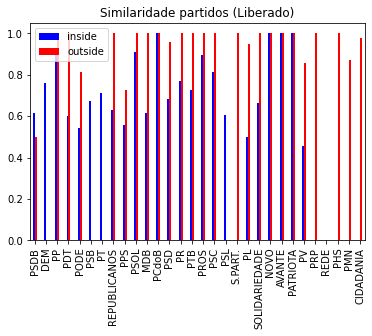

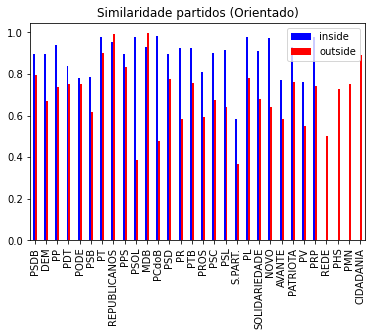

In [124]:
plot_bar_graph(sim_l, outside_sim_l, {"file": "free", "name": "Liberado"})
plot_bar_graph(sim_o, outside_sim_o, {"file": "guided", "name": "Orientado"})

In [72]:
def calculate_dep_sim_diff(inside_sim, outside_sim):
    diff = {}
    for k, v in inside_sim.items():
        try:
           diff[k] = v-outside_sim[k]
        except:
            pass
    return diff

diff_l = calculate_dep_sim_diff(inside_sim_nodes_l, outside_sim_nodes_l)
diff_o = calculate_dep_sim_diff(inside_sim_nodes_o, outside_sim_nodes_o)

In [120]:
parties_dp_count = pd.DataFrame(votes_grouped_df.groupby(by=["siglaBancada"])['siglaBancada'].count())
parties_dp_count = parties_dp_count.rename(columns={"siglaBancada": "N deputados"}).reset_index()
parties_dp_count = parties_dp_count.groupby(by=['N deputados'], as_index=False)['siglaBancada'].apply(', '.join).reset_index(drop=True)
parties_dp_count = parties_dp_count.sort_values(by=['N deputados'], ascending=False)
parties_dp_count = parties_dp_count.rename(columns={"siglaBancada": "Sigla"}).reset_index()
parties_dp_count = parties_dp_count[["Sigla", "N deputados"]]

print(parties_dp_count.to_latex(index=False))

\begin{tabular}{lr}
\toprule
               Sigla &  N deputados \\
\midrule
                  PT &           58 \\
                 PSL &           56 \\
                  PL &           50 \\
                  PP &           43 \\
                 PSD &           42 \\
       MDB, PR, PSDB &           39 \\
        REPUBLICANOS &           38 \\
                 PSB &           37 \\
                 DEM &           34 \\
                 PRB &           31 \\
                 PDT &           30 \\
                PODE &           16 \\
       SOLIDARIEDADE &           15 \\
           PROS, PSC &           13 \\
                 PTB &           12 \\
                PSOL &           11 \\
   AVANTE, CIDADANIA &           10 \\
               PCdoB &            9 \\
           NOVO, PPS &            8 \\
PATRI, PATRIOTA, PHS &            6 \\
                  PV &            4 \\
   PMN, PRP, S.PART. &            3 \\
                 PTC &            2 \\
       DC, PPL, REDE &    